# Loading data
---
Data is from a self-made dataset, **1000** images.

**5** categories:
1. *basic*
2. *double*
3. *loud*
4. *thinking*
5. *narration*

In [15]:
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import numpy as np
import cv2
import os

In [2]:
categories = ['basic', 'double', 'loud', 'thinking', 'narration']

def load_data(data_path):
    data = {}
    for category in categories:
        category_path = os.path.join(data_path, category)
        files = os.listdir(category_path)
        data[category] = [os.path.join(category_path, file) for file in files]

    train_data = {}
    test_data = {}

    for category, files in data.items():
        train_files, val_files = train_test_split(files, test_size=0.1, random_state=42)
        train_data[category] = train_files
        test_data[category] = val_files

    X = []
    y = []

    for category, files in data.items():
        for filePath in files:
            img = image.load_img(filePath)
            X.append(image.img_to_array(img))
            y.append(categories.index(category))
            
    X = np.array(X) / 255.0
    y = np.array(y)
    
    return train_data, test_data, X, y

def display_images(file_paths, category, dataset):
    plt.figure(figsize=(15, 5))
    for i, file_path in enumerate(file_paths[:5]):
        plt.subplot(1, 5, i+1)
        img = mpimg.imread(file_path)
        plt.imshow(img)
        plt.title(f'{i+1}. {category}')
        plt.axis('off')
    plt.show()

def data_summary(title, x, y, data):
    plt.figure(figsize=(15, 2))
    plt.title(f"{title} Data Summary", fontsize=24)
    plt.text(0.1, 0.8, f"X Train Shape: {x.shape}", fontsize=12)
    plt.text(0.1, 0.65, f"Y Train Shape: {y.shape}", fontsize=12)
    y_pos = 0.4
    for category, files in train_data.items():
        plt.text(0.1, y_pos, f"Category {category}: {len(files)}", fontsize=12)
        y_pos -= 0.15
    plt.axis('off')
    plt.show()

    for category, files in data.items():
        display_images(files, category, "Train")
        
def plot_model_history(history, name):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Train')
    plt.plot(val_accuracy, label='Validation')
    plt.legend()
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train')
    plt.plot(val_loss, label='Validation')
    plt.legend()
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.savefig(f"models/models_plots/{name}.png", dpi=300)
    plt.show()

In [3]:
train_data, test_data, X, y = load_data("data/")

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(f"x_train.shape:{x_train.shape}")
print(f"x_test.shape:{x_test.shape}")
print(f"y_train.shape:{y_train.shape}")
print(f"y_test.shape:{y_test.shape}")

x_train.shape:(900, 256, 256, 3)
x_test.shape:(100, 256, 256, 3)
y_train.shape:(900,)
y_test.shape:(100,)


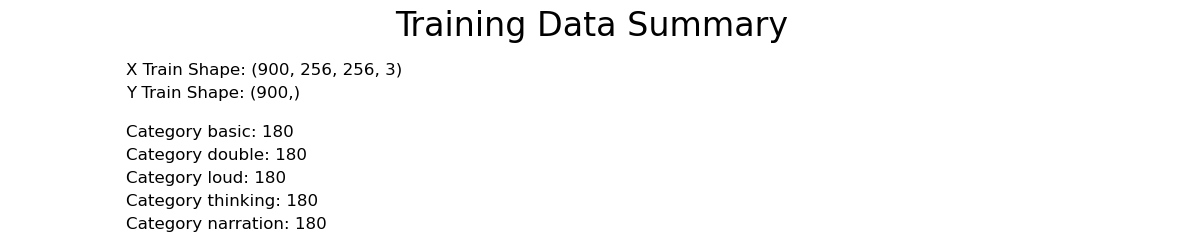

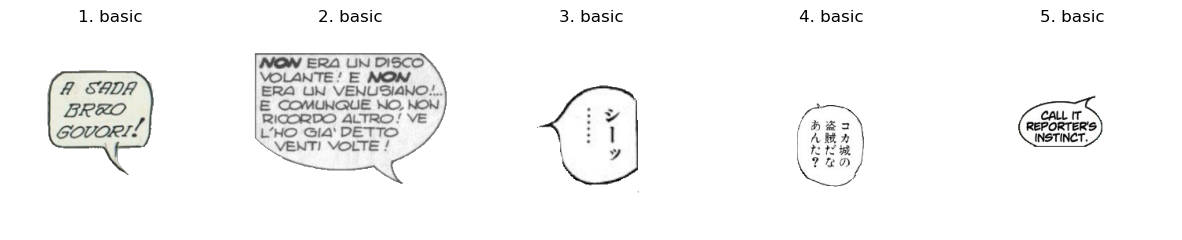

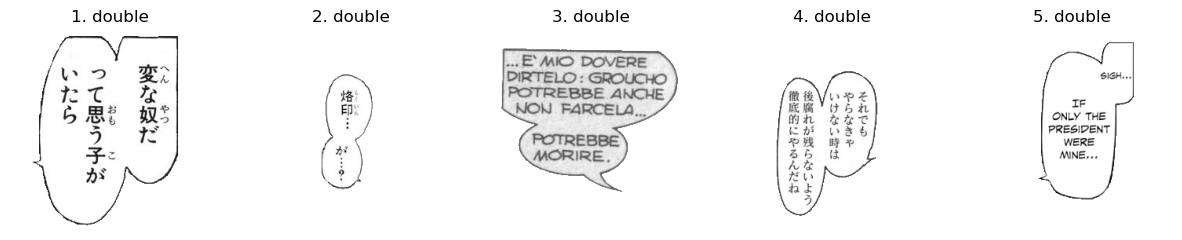

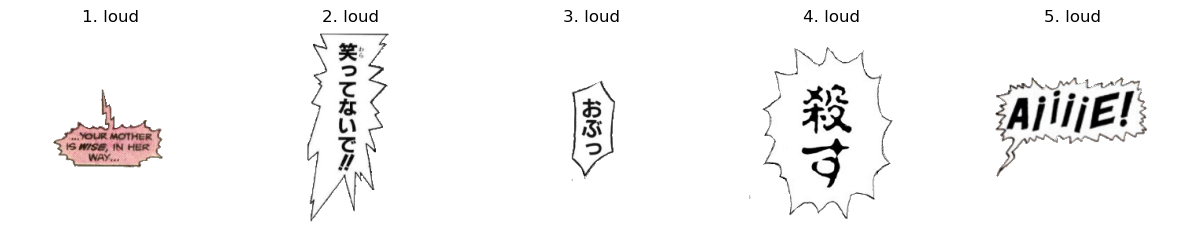

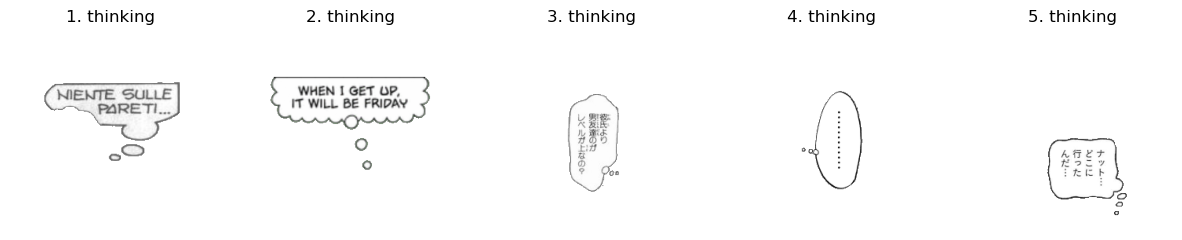

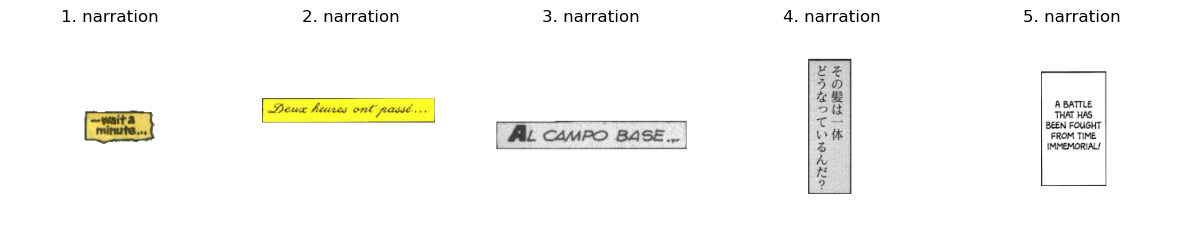

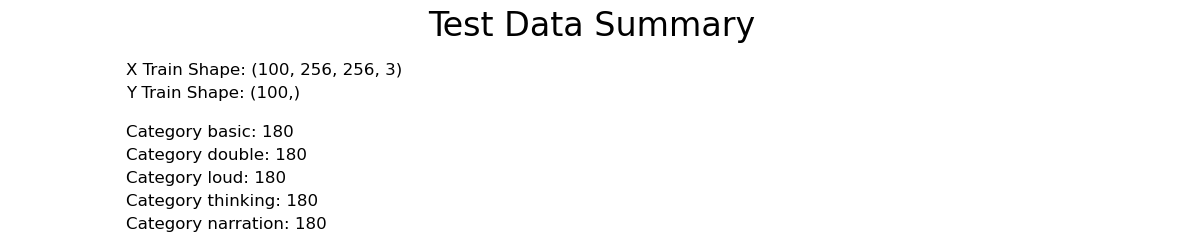

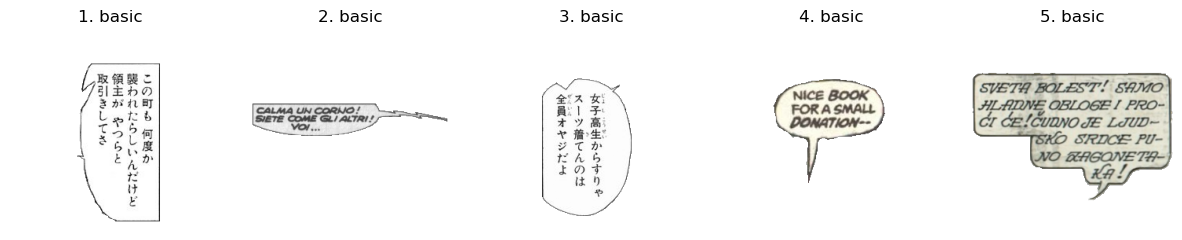

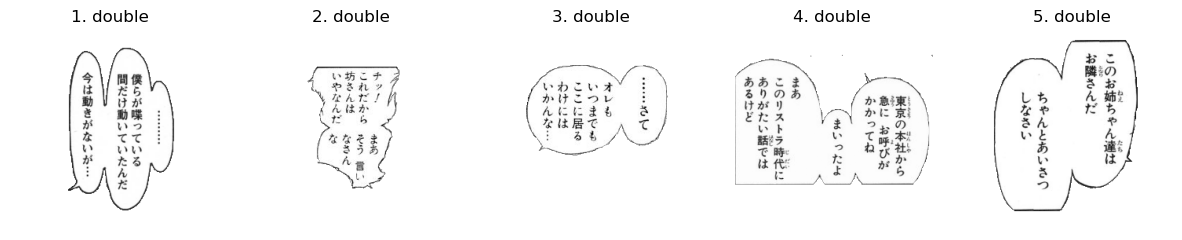

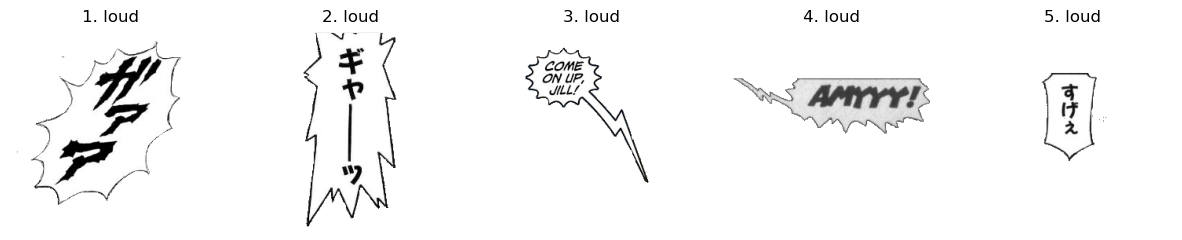

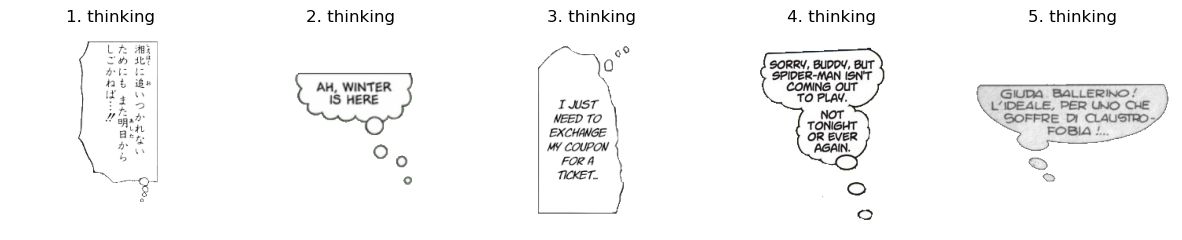

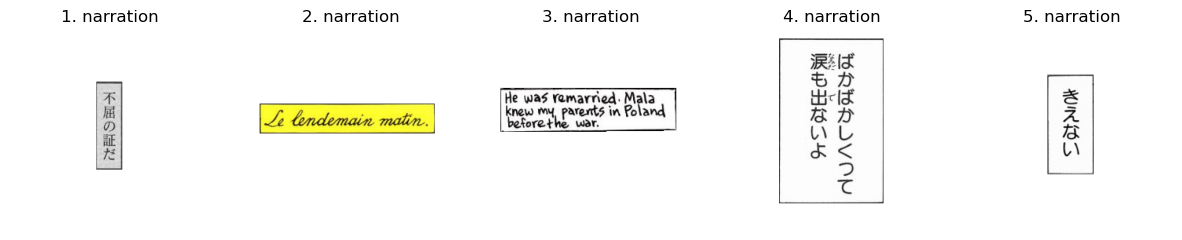

In [4]:
data_summary("Training", x_train, y_train, train_data)
data_summary("Test", x_test, y_test, test_data)

# Training model
---
## Step 1 - Checking initial loss
## First basic model
#### **7** layers:
- **2** **convolutional** layers:
 - convolutional layer with **32** filters of size **3x3**, using **ReLU** activation function
 - convolutional layer with **64** filters of size **3x3**, using **ReLU** activation function
- **2** **max pooling** layers with a pool size of **2x2**, reducing the spatial dimensions
- **1** **flatten** layer transforming the multi-dimensional output into a one-dimensional array, necessary before passing the data to a densely connected layer
- **2** **dense** layers - allowing connections between every input neuron and every output neuron
 - **densely connected** layer with **32** units and **ReLU** activation
 - **output** layer, has as many units as there are categories with a **softmax** activation function used for multi-class classification, assigns probabilities to each category, with the sum of probabilities equaling **1**

#### Compiling
- **Adam optimizer** for adjusting the weights in the network to minimize the loss function.
- **Sparse Categorical Crossentropy** loss function used for training the model, measures the error between the predicted and actual labels.
- **Accuracy** metric, used during training for printing out accuracy

In [5]:
def create_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(categories), activation='softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 32)                7

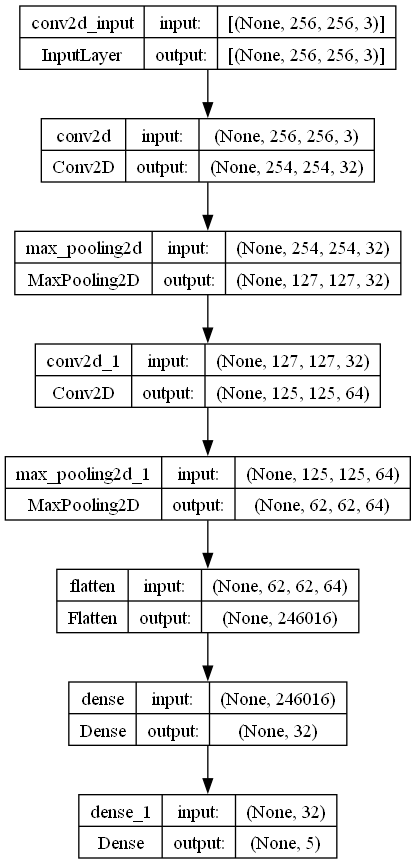

In [6]:
model = create_model(x_train[0].shape)
model.summary()

plot_model(model, to_file='models/models_summary_images/model_1_summary.png', show_shapes=True, show_layer_names=True)

In [7]:
initial_loss, initial_accuracy = model.evaluate(x_test, y_test)

print(f"Initial loss: {initial_loss:.4f}")
print(f"Initial accuracy: {initial_accuracy:.4f}")

4/4 [==============================] - 1s 26ms/step - loss: 1.6006 - accuracy: 0.2300
Initial loss: 1.6006
Initial accuracy: 0.2300


### Results - model 1 - no training
---

#### Initial Loss
- ~160%

#### Initial Accuracy
- ~23% which is expected

## Step 2 - Overfiting for small sample
---
### Model same as first one
 - Using 1000 images split 900|100
 - Image size is 256x256 and normalized using Min-Max Scaling
### Training

In [8]:
batch_size = 32
epochs = 10

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=1)

model.save('models/trained_models/model_1.keras')

Epoch 1/10
29/29 [==============================] - 2s 51ms/step - loss: 1.6629 - accuracy: 0.2900 - val_loss: 1.4712 - val_accuracy: 0.3700
Epoch 2/10
29/29 [==============================] - 1s 47ms/step - loss: 1.2928 - accuracy: 0.5256 - val_loss: 1.2611 - val_accuracy: 0.5300
Epoch 3/10
29/29 [==============================] - 1s 46ms/step - loss: 0.6592 - accuracy: 0.7911 - val_loss: 1.2672 - val_accuracy: 0.5100
Epoch 4/10
29/29 [==============================] - 1s 46ms/step - loss: 0.2025 - accuracy: 0.9589 - val_loss: 1.4822 - val_accuracy: 0.5400
Epoch 5/10
29/29 [==============================] - 1s 47ms/step - loss: 0.0610 - accuracy: 0.9911 - val_loss: 2.0648 - val_accuracy: 0.5300
Epoch 6/10
29/29 [==============================] - 1s 47ms/step - loss: 0.0167 - accuracy: 0.9967 - val_loss: 2.1855 - val_accuracy: 0.5700
Epoch 7/10
29/29 [==============================] - 1s 47ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 2.3762 - val_accuracy: 0.5600
Epoch 8/10
29

In [9]:
train_loss, train_accuracy = model.evaluate(x_train, y_train)
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Train Accuracy: {train_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

4/4 [==============================] - 0s 10ms/step - loss: 2.6092 - accuracy: 0.5700
Train Accuracy: 100.00%
Test Accuracy: 57.00%


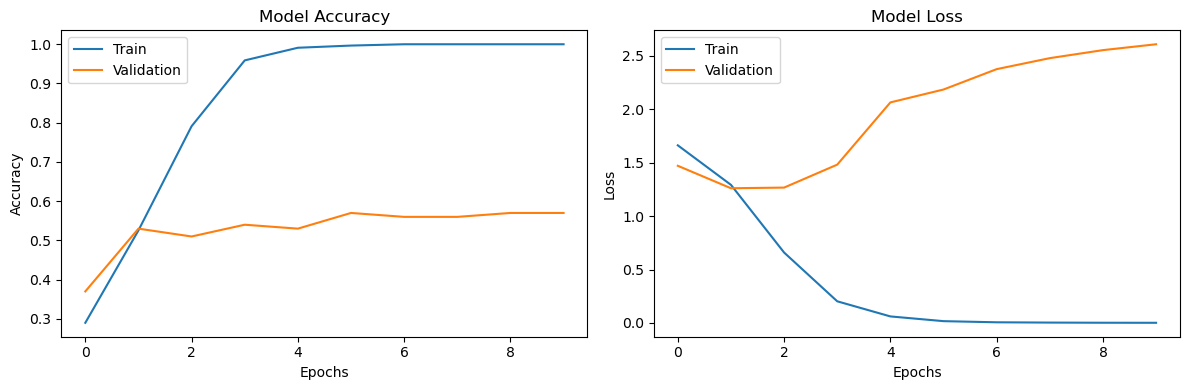

In [10]:
plot_model_history(history, "model_1_plot")

### Results - model 1
---
#### Train Accuracy
- increases to 100% and remains at 100%

#### Test Accuracy
- starts at ~37%, increases to ~57%, then plateu

#### Train Loss
- decreases to ~0%

#### Test Loss
- starts at ~160%, plateu, then increases to ~260%

Big gaps between lines in both graphs indicate huge overfiting.

## Data Augmentation

Data augmentation will be used to artificially increase the diversity of a training dataset by applying various transformations to the existing data.

#### Augmentation Techniques:

- **Rotating** the image up to 15 degrees
- **Shifting** the image horizontally and vertically by a fraction of the total width and height
- **Shear** transformation
- **Zooming** in on the image
- **Fliping** the image horizontally and vertically

In [8]:
def augment_images(save_path, augmentations=2):
    datagen = image.ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    augmented_data = {}

    for category in categories:
        category_path = os.path.join("data/", category)
        files = os.listdir(category_path)
        augmented_data[category] = []

        for file in files:
            image_path = os.path.join(category_path, file)
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.reshape((1,) + img.shape)  # Add batch dimension

            # Generate augmented images
            augmented_images = [datagen.flow(img, batch_size=1)[0][0] for _ in range(augmentations)]
            augmented_images = [cv2.cvtColor(img, cv2.COLOR_RGB2BGR) for img in augmented_images]

            # Save original image
            original_save_path = os.path.join(save_path, category)
            os.makedirs(original_save_path, exist_ok=True)
            cv2.imwrite(os.path.join(original_save_path, file), cv2.cvtColor(img[0], cv2.COLOR_RGB2BGR))

            # Save augmented images
            augmented_save_path = os.path.join(save_path, category)
            os.makedirs(augmented_save_path, exist_ok=True)
            for i, augmented_image in enumerate(augmented_images):
                cv2.imwrite(os.path.join(augmented_save_path, f"{file.split('.')[0]}_augmented_{i}.jpg"), augmented_image)

            augmented_data[category].extend(augmented_images)
            print(f"Created {augmentations} augmented images for image {file.split('.')[0]} for category {category}") 

augment_images("data_augmented", 2)

Created 2 augmented images for image 1 for category basic
Created 2 augmented images for image 10 for category basic
Created 2 augmented images for image 100 for category basic
Created 2 augmented images for image 101 for category basic
Created 2 augmented images for image 102 for category basic
Created 2 augmented images for image 103 for category basic
Created 2 augmented images for image 104 for category basic
Created 2 augmented images for image 105 for category basic
Created 2 augmented images for image 106 for category basic
Created 2 augmented images for image 107 for category basic
Created 2 augmented images for image 108 for category basic
Created 2 augmented images for image 109 for category basic
Created 2 augmented images for image 11 for category basic
Created 2 augmented images for image 110 for category basic
Created 2 augmented images for image 111 for category basic
Created 2 augmented images for image 112 for category basic
Created 2 augmented images for image 113 for

Created 2 augmented images for image 51 for category basic
Created 2 augmented images for image 52 for category basic
Created 2 augmented images for image 53 for category basic
Created 2 augmented images for image 54 for category basic
Created 2 augmented images for image 55 for category basic
Created 2 augmented images for image 56 for category basic
Created 2 augmented images for image 57 for category basic
Created 2 augmented images for image 58 for category basic
Created 2 augmented images for image 59 for category basic
Created 2 augmented images for image 6 for category basic
Created 2 augmented images for image 60 for category basic
Created 2 augmented images for image 61 for category basic
Created 2 augmented images for image 62 for category basic
Created 2 augmented images for image 63 for category basic
Created 2 augmented images for image 64 for category basic
Created 2 augmented images for image 65 for category basic
Created 2 augmented images for image 66 for category basi

Created 2 augmented images for image 175 for category double
Created 2 augmented images for image 176 for category double
Created 2 augmented images for image 177 for category double
Created 2 augmented images for image 178 for category double
Created 2 augmented images for image 179 for category double
Created 2 augmented images for image 18 for category double
Created 2 augmented images for image 180 for category double
Created 2 augmented images for image 181 for category double
Created 2 augmented images for image 182 for category double
Created 2 augmented images for image 183 for category double
Created 2 augmented images for image 184 for category double
Created 2 augmented images for image 185 for category double
Created 2 augmented images for image 186 for category double
Created 2 augmented images for image 187 for category double
Created 2 augmented images for image 188 for category double
Created 2 augmented images for image 189 for category double
Created 2 augmented image

Created 2 augmented images for image 125 for category loud
Created 2 augmented images for image 126 for category loud
Created 2 augmented images for image 127 for category loud
Created 2 augmented images for image 128 for category loud
Created 2 augmented images for image 129 for category loud
Created 2 augmented images for image 13 for category loud
Created 2 augmented images for image 130 for category loud
Created 2 augmented images for image 131 for category loud
Created 2 augmented images for image 132 for category loud
Created 2 augmented images for image 133 for category loud
Created 2 augmented images for image 134 for category loud
Created 2 augmented images for image 135 for category loud
Created 2 augmented images for image 136 for category loud
Created 2 augmented images for image 137 for category loud
Created 2 augmented images for image 138 for category loud
Created 2 augmented images for image 139 for category loud
Created 2 augmented images for image 14 for category loud

Created 2 augmented images for image 74 for category loud
Created 2 augmented images for image 75 for category loud
Created 2 augmented images for image 76 for category loud
Created 2 augmented images for image 77 for category loud
Created 2 augmented images for image 78 for category loud
Created 2 augmented images for image 79 for category loud
Created 2 augmented images for image 8 for category loud
Created 2 augmented images for image 80 for category loud
Created 2 augmented images for image 81 for category loud
Created 2 augmented images for image 82 for category loud
Created 2 augmented images for image 83 for category loud
Created 2 augmented images for image 84 for category loud
Created 2 augmented images for image 85 for category loud
Created 2 augmented images for image 86 for category loud
Created 2 augmented images for image 87 for category loud
Created 2 augmented images for image 88 for category loud
Created 2 augmented images for image 89 for category loud
Created 2 augme

Created 2 augmented images for image 195 for category thinking
Created 2 augmented images for image 196 for category thinking
Created 2 augmented images for image 197 for category thinking
Created 2 augmented images for image 198 for category thinking
Created 2 augmented images for image 199 for category thinking
Created 2 augmented images for image 2 for category thinking
Created 2 augmented images for image 20 for category thinking
Created 2 augmented images for image 200 for category thinking
Created 2 augmented images for image 21 for category thinking
Created 2 augmented images for image 22 for category thinking
Created 2 augmented images for image 23 for category thinking
Created 2 augmented images for image 24 for category thinking
Created 2 augmented images for image 25 for category thinking
Created 2 augmented images for image 26 for category thinking
Created 2 augmented images for image 27 for category thinking
Created 2 augmented images for image 28 for category thinking
Cre

Created 2 augmented images for image 137 for category narration
Created 2 augmented images for image 138 for category narration
Created 2 augmented images for image 139 for category narration
Created 2 augmented images for image 14 for category narration
Created 2 augmented images for image 140 for category narration
Created 2 augmented images for image 141 for category narration
Created 2 augmented images for image 142 for category narration
Created 2 augmented images for image 143 for category narration
Created 2 augmented images for image 144 for category narration
Created 2 augmented images for image 145 for category narration
Created 2 augmented images for image 146 for category narration
Created 2 augmented images for image 147 for category narration
Created 2 augmented images for image 148 for category narration
Created 2 augmented images for image 149 for category narration
Created 2 augmented images for image 15 for category narration
Created 2 augmented images for image 150 f

Created 2 augmented images for image 84 for category narration
Created 2 augmented images for image 85 for category narration
Created 2 augmented images for image 86 for category narration
Created 2 augmented images for image 87 for category narration
Created 2 augmented images for image 88 for category narration
Created 2 augmented images for image 89 for category narration
Created 2 augmented images for image 9 for category narration
Created 2 augmented images for image 90 for category narration
Created 2 augmented images for image 91 for category narration
Created 2 augmented images for image 92 for category narration
Created 2 augmented images for image 93 for category narration
Created 2 augmented images for image 94 for category narration
Created 2 augmented images for image 95 for category narration
Created 2 augmented images for image 96 for category narration
Created 2 augmented images for image 97 for category narration
Created 2 augmented images for image 98 for category nar

In [3]:
train_data, test_data, X, y = load_data("data_augmented/")

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(f"x_train.shape:{x_train.shape}")
print(f"x_test.shape:{x_test.shape}")
print(f"y_train.shape:{y_train.shape}")
print(f"y_test.shape:{y_test.shape}")

x_train.shape:(2700, 256, 256, 3)
x_test.shape:(300, 256, 256, 3)
y_train.shape:(2700,)
y_test.shape:(300,)


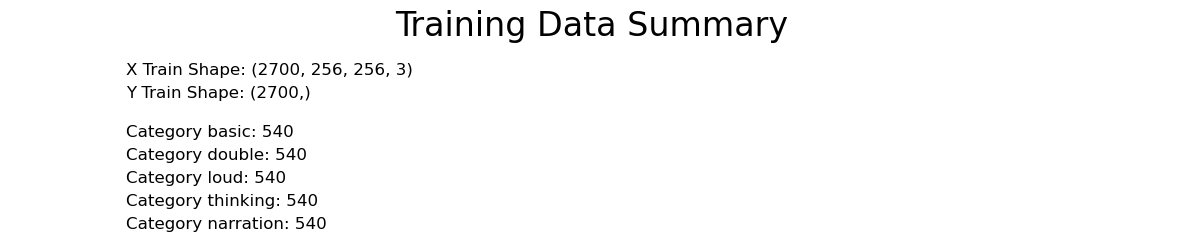

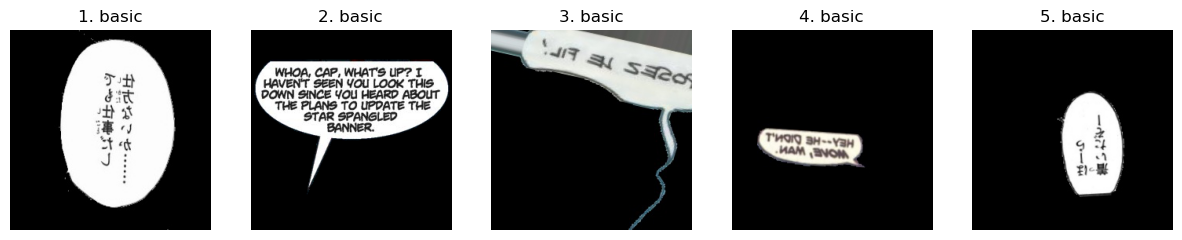

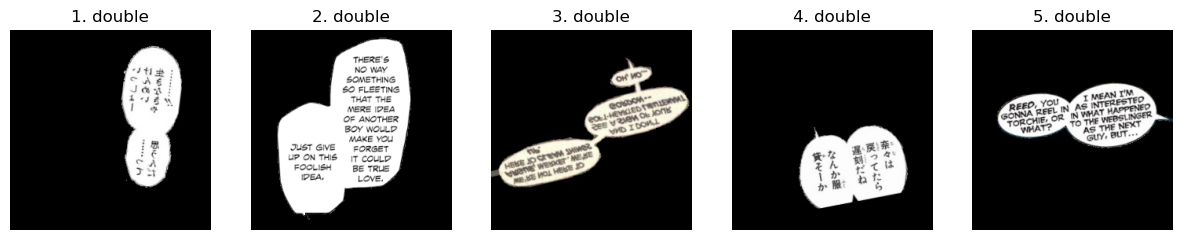

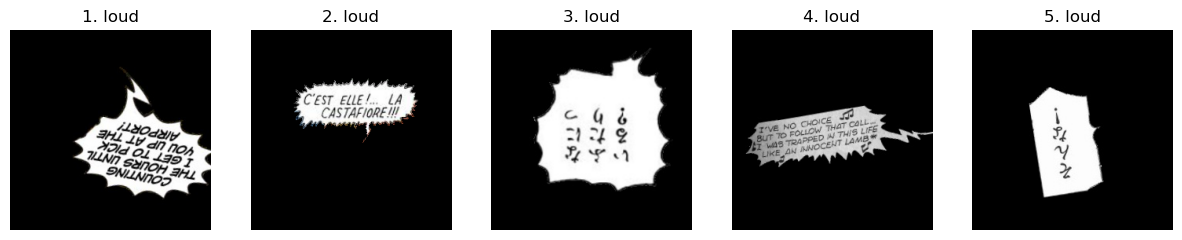

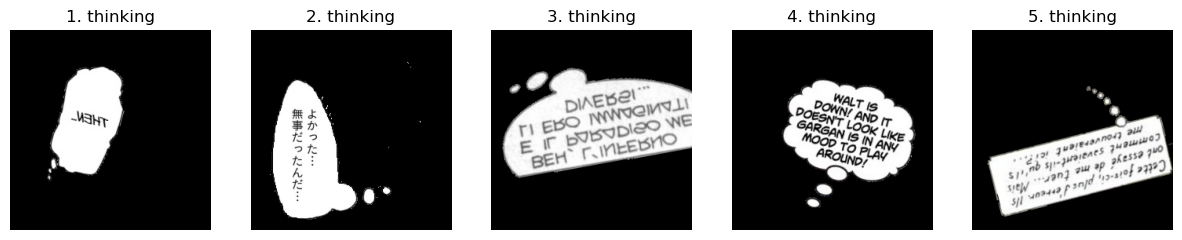

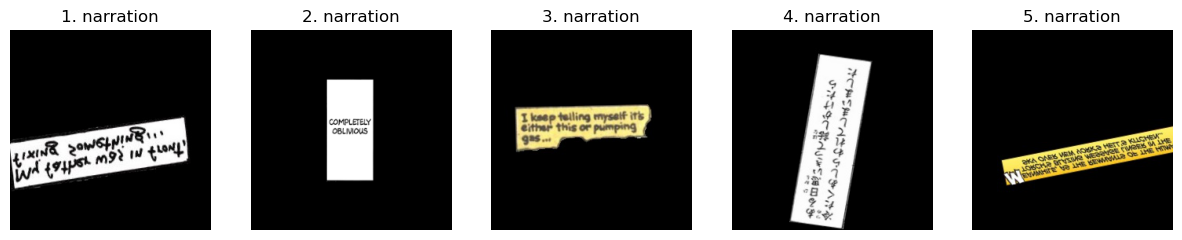

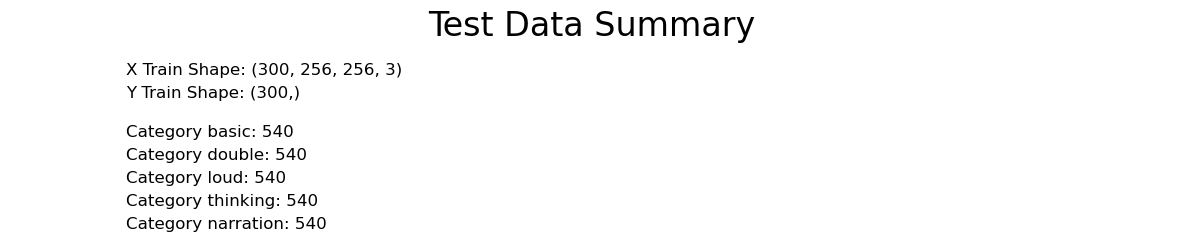

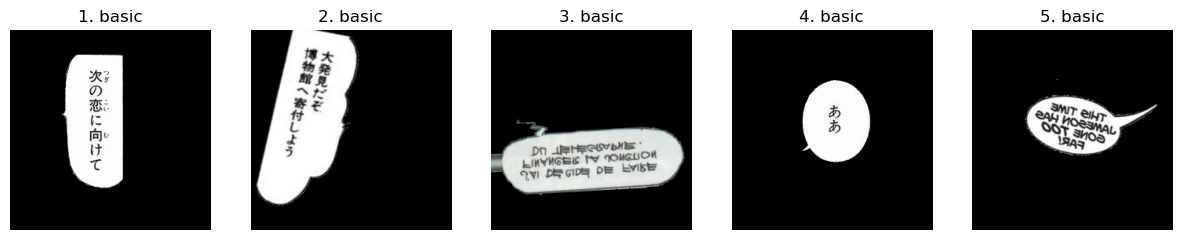

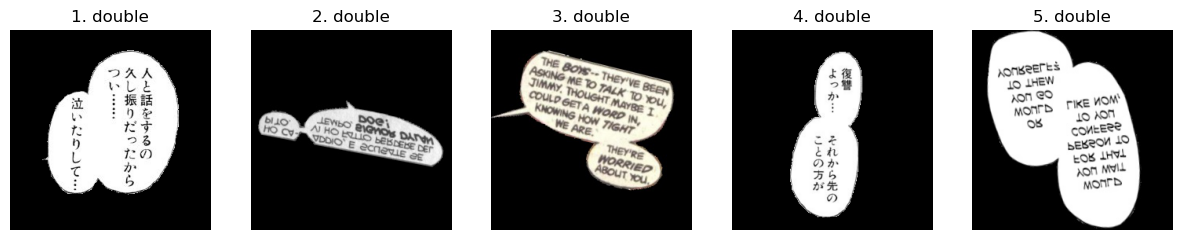

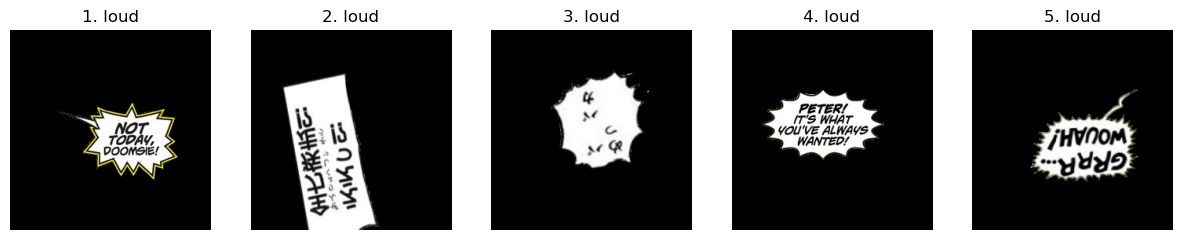

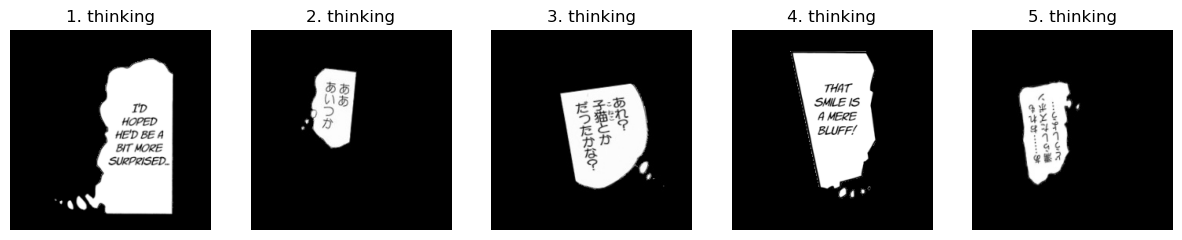

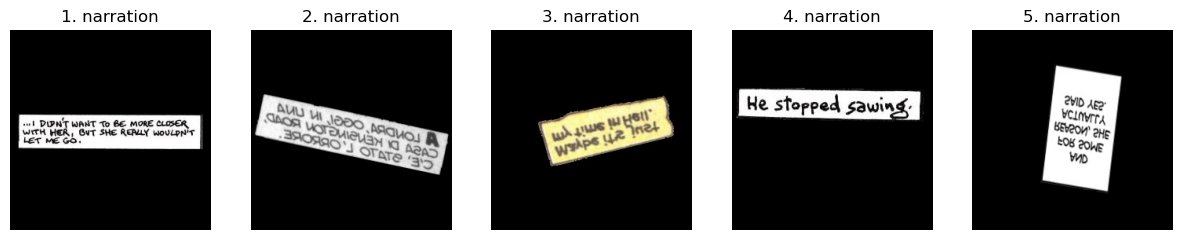

In [10]:
data_summary("Training", x_train, y_train, train_data)
data_summary("Test", x_test, y_test, test_data)

## Step 3 - Using augmented data and reducing overfitting
---
## 2. model
To prevent overfitting following features were added:
- **L2 regularization** makes the model's weights more spread out and less prone to fitting to noise in the data
- **dropout** layer prevents overfitting by reducing the reliance on specific neurons in the network

#### **8** layers:
- **2** **convolutional** layers:
 - convolutional layer with **32** filters of size **3x3**, using **ReLU** activation function
 - convolutional layer with **64** filters of size **3x3**, using **ReLU** activation function
- **3** **batch normalization** to stabilize and improve the training process by normalizing the inputs for each mini-batch
- **2** **max pooling** layers with a pool size of **2x2**, reducing the spatial dimensions
- **1** **flatten** layer
- **2** **dense** layers:
 - **densely connected** layer with **32** units, **ReLU** activation and **L2 regularization** with a regularization strength of **0.001** 
 - **output** layer, has as many units as there are categories with a **softmax** activation function
- **1** **dropout** layer with dropout rate of **0.1**

#### Compiling
- **Adam optimizer** with learning rate **0.005** for adjusting the weights in the network to minimize the loss function.
- **Sparse Categorical Crossentropy** loss function used for training the model, measures the error between the predicted and actual labels.
- **Accuracy** metric, used during training for printing out accuracy

In [14]:
initial_learning_rate=0.005

def create_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    
    model.add(Dense(len(categories), activation='softmax'))
    model.add(Dropout(0.01))    

    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)     256       
 hNormalization)                                                 
                                                      

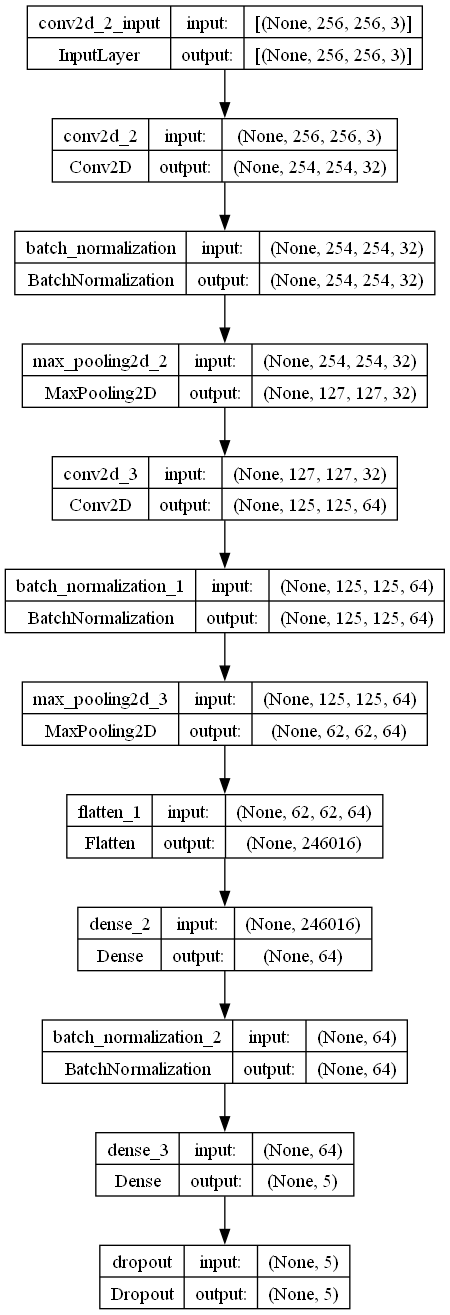

In [15]:
model = create_model(x_train[0].shape)
model.summary()

plot_model(model, to_file='models/models_summary_images/model_2_summary.png', show_shapes=True, show_layer_names=True)

In [16]:
batch_size = 32
epochs = 10

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=1)

model.save('models/trained_models/model_2.keras')

Epoch 1/10
85/85 [==============================] - 7s 76ms/step - loss: 9.2532 - accuracy: 0.3793 - val_loss: 10.8433 - val_accuracy: 0.1933
Epoch 2/10
85/85 [==============================] - 6s 70ms/step - loss: 5.5464 - accuracy: 0.4589 - val_loss: 6.3636 - val_accuracy: 0.2400
Epoch 3/10
85/85 [==============================] - 6s 70ms/step - loss: 3.7726 - accuracy: 0.5226 - val_loss: 5.5788 - val_accuracy: 0.2067
Epoch 4/10
85/85 [==============================] - 6s 70ms/step - loss: 2.9577 - accuracy: 0.6011 - val_loss: 6.7120 - val_accuracy: 0.1900
Epoch 5/10
85/85 [==============================] - 6s 70ms/step - loss: 2.6366 - accuracy: 0.6856 - val_loss: 6.8978 - val_accuracy: 0.1900
Epoch 6/10
85/85 [==============================] - 6s 70ms/step - loss: 2.9866 - accuracy: 0.7381 - val_loss: 9.4953 - val_accuracy: 0.2000
Epoch 7/10
85/85 [==============================] - 6s 70ms/step - loss: 4.0389 - accuracy: 0.7615 - val_loss: 8.8395 - val_accuracy: 0.1900
Epoch 8/10
8

In [17]:
train_loss, train_accuracy = model.evaluate(x_train, y_train)
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print(f"Train Accuracy: {train_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

10/10 [==============================] - 0s 18ms/step - loss: 4.0720 - accuracy: 0.4833
Train Accuracy: 88.44%
Test Accuracy: 48.33%


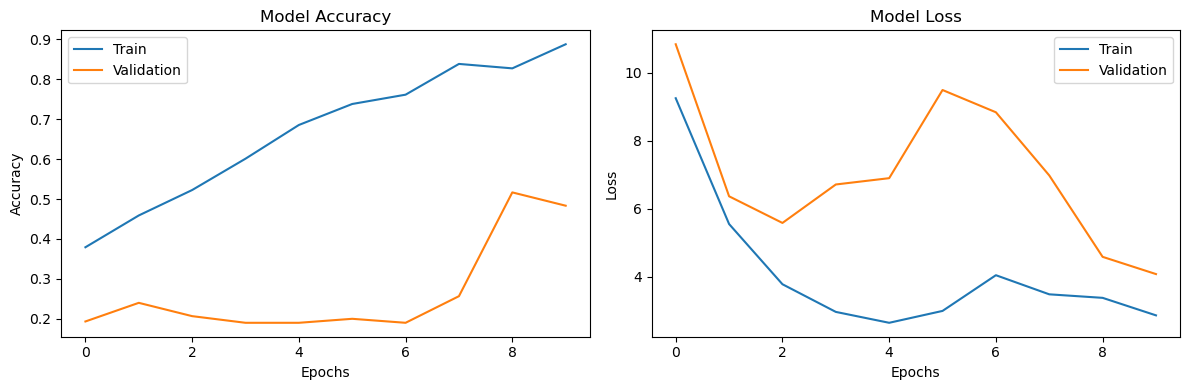

In [18]:
plot_model_history(history, "model_2_plot")

### Results - model 2
---
#### Train Accuracy
- slowly increases to ~88%, overfiting was reduced a little

#### Test Accuracy
- starts at ~19%, plateu, but then start increasing to ~51%

#### Train Loss
- decreases to ~285%

#### Test Loss
- starts at ~1084%, decreases and increases to ~949% after which it start decreasing rapidly closing the gap and reaching 407%

There are still big gaps between lines in both graphs, but we can see that at the end, gap started closing in.

## Step 4 - Training longer and tweaking
---
## 3. Model
- increased droput rate to 0.1

### Compiling
- decreased learning rate to 0.001

### Training
- increased epochs to 20

In [19]:
initial_learning_rate=0.001

def create_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    
    model.add(Dense(len(categories), activation='softmax'))
    model.add(Dropout(0.1))    

    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 254, 254, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_4 (Batc  (None, 125, 125, 64)     256       
 hNormalization)                                                 
                                                      

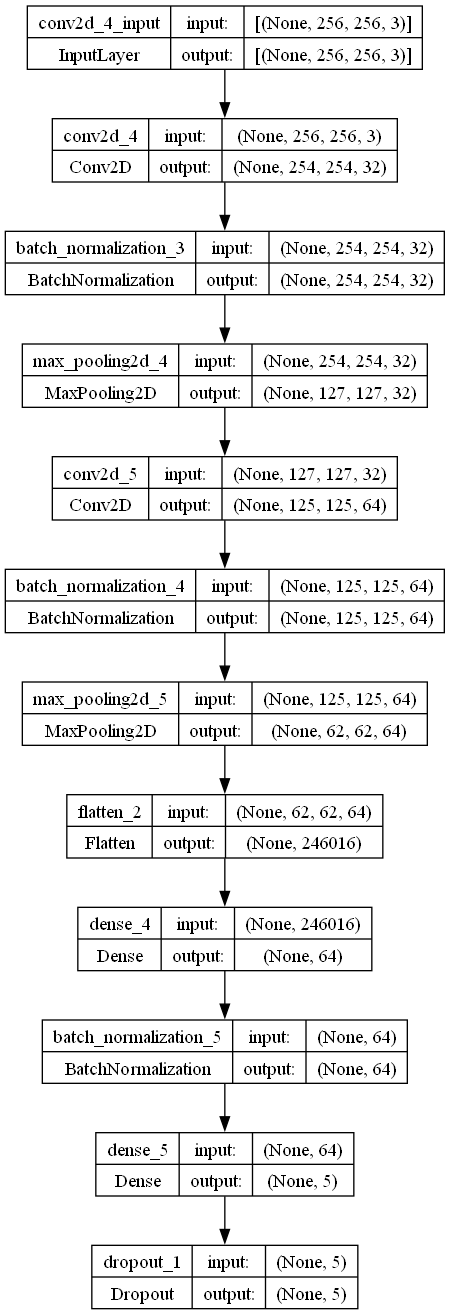

In [20]:
model = create_model(x_train[0].shape)
model.summary()

plot_model(model, to_file='models/models_summary_images/model_3_summary.png', show_shapes=True, show_layer_names=True)

In [21]:
batch_size = 32
epochs = 20

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=1)

model.save('models/trained_models/model_3.keras')

Epoch 1/20
85/85 [==============================] - 7s 73ms/step - loss: 3.3844 - accuracy: 0.3381 - val_loss: 2.4163 - val_accuracy: 0.1900
Epoch 2/20
85/85 [==============================] - 6s 71ms/step - loss: 3.1390 - accuracy: 0.4804 - val_loss: 3.9223 - val_accuracy: 0.1933
Epoch 3/20
85/85 [==============================] - 6s 73ms/step - loss: 2.8591 - accuracy: 0.6244 - val_loss: 4.9834 - val_accuracy: 0.1900
Epoch 4/20
85/85 [==============================] - 7s 83ms/step - loss: 2.6101 - accuracy: 0.7574 - val_loss: 7.0248 - val_accuracy: 0.1900
Epoch 5/20
85/85 [==============================] - 6s 71ms/step - loss: 2.4268 - accuracy: 0.8007 - val_loss: 6.9544 - val_accuracy: 0.1967
Epoch 6/20
85/85 [==============================] - 6s 70ms/step - loss: 2.4096 - accuracy: 0.8219 - val_loss: 4.6834 - val_accuracy: 0.2500
Epoch 7/20
85/85 [==============================] - 6s 70ms/step - loss: 2.2618 - accuracy: 0.8478 - val_loss: 4.1426 - val_accuracy: 0.2767
Epoch 8/20
85

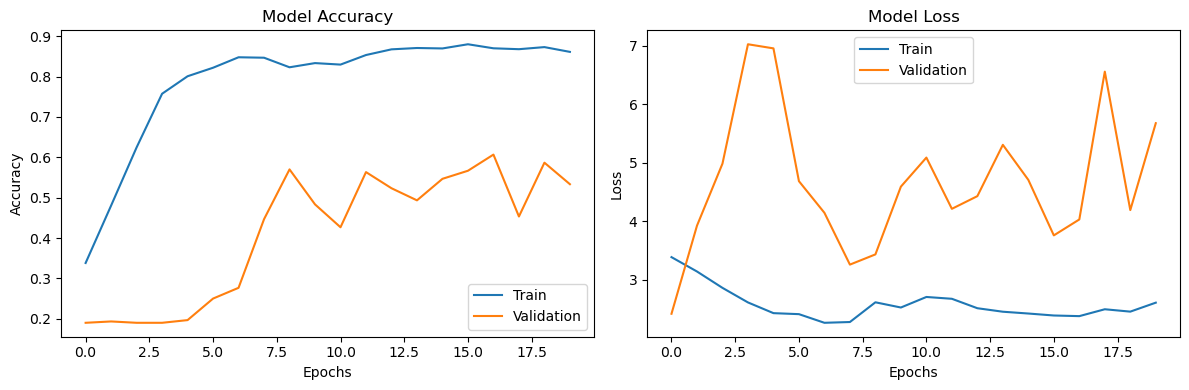

In [22]:
plot_model_history(history, "model_3_plot")

### Results - model 3
---
#### Train Accuracy
- increases to ~80%, and from here it slowly climbs to 86% and plateu

#### Test Accuracy
- starts at ~22%, increases to ~60%, improvement but line is jumpy which means learning rate is to high in later epochs

#### Train Loss
- decreases to ~26%

#### Test Loss
- reached 567% but line is jumpy which also indicates that learning rate is big

There are still big gaps between lines in both graphs which indicates big overfitting, learning rate is also high and should reduce over time

## Step 5 - Adding more layers
---
## 4. model

#### **23** layers:
- **6** **convolutional** layers:
 - convolutional layer with **32** filters of size **3x3**, using **ReLU** activation function
 - convolutional layer with **32** filters of size **5x5**, using **ReLU** activation function
 - convolutional layer with **32** filters of size **7x7**, using **ReLU** activation function
 - convolutional layer with **64** filters of size **3x3**, using **ReLU** activation function
 - convolutional layer with **64** filters of size **5x5**, using **ReLU** activation function
 - convolutional layer with **128** filters of size **3x3**, using **ReLU** activation function
- **7** **batch normalization** to stabilize and improve the training process by normalizing the inputs for each mini-batch
- **6** **max pooling** layers with a pool size of **2x2**, reducing the spatial dimensions
- **1** **flatten** layer
- **2** **dense** layers:
 - **densely connected** layer with **32** units, **ReLU** activation and **L2 regularization** with a regularization strength of **0.001** 
 - **output** layer, has as many units as there are categories with a **softmax** activation function
- **1** **dropout** layer with dropout rate of **0.2**

#### Compiling
- **Adam optimizer** with learning rate **0.001** for adjusting the weights in the network to minimize the loss function
- **Sparse Categorical Crossentropy** loss function used for training the model, measures the error between the predicted and actual labels
- **Accuracy** metric, used during training for printing out accuracy

#### Training
- Added **learning rate scheduler** which reduced learning rate by a factor of **0.9** every epoch
- Added **early stopping** where if the validation loss does not improve for 10 consecutive epochs, the training process will be stopped

In [4]:
initial_learning_rate=0.001

def create_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(32, (5, 5), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(32, (7, 7), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    
    model.add(Dense(len(categories), activation='softmax'))
    model.add(Dropout(0.2))    

    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 123, 123, 32)      25632     
                                                                 
 batch_normalization_1 (Batc  (None, 123, 123, 32)     128       
 hNormalization)                                                 
                                                        

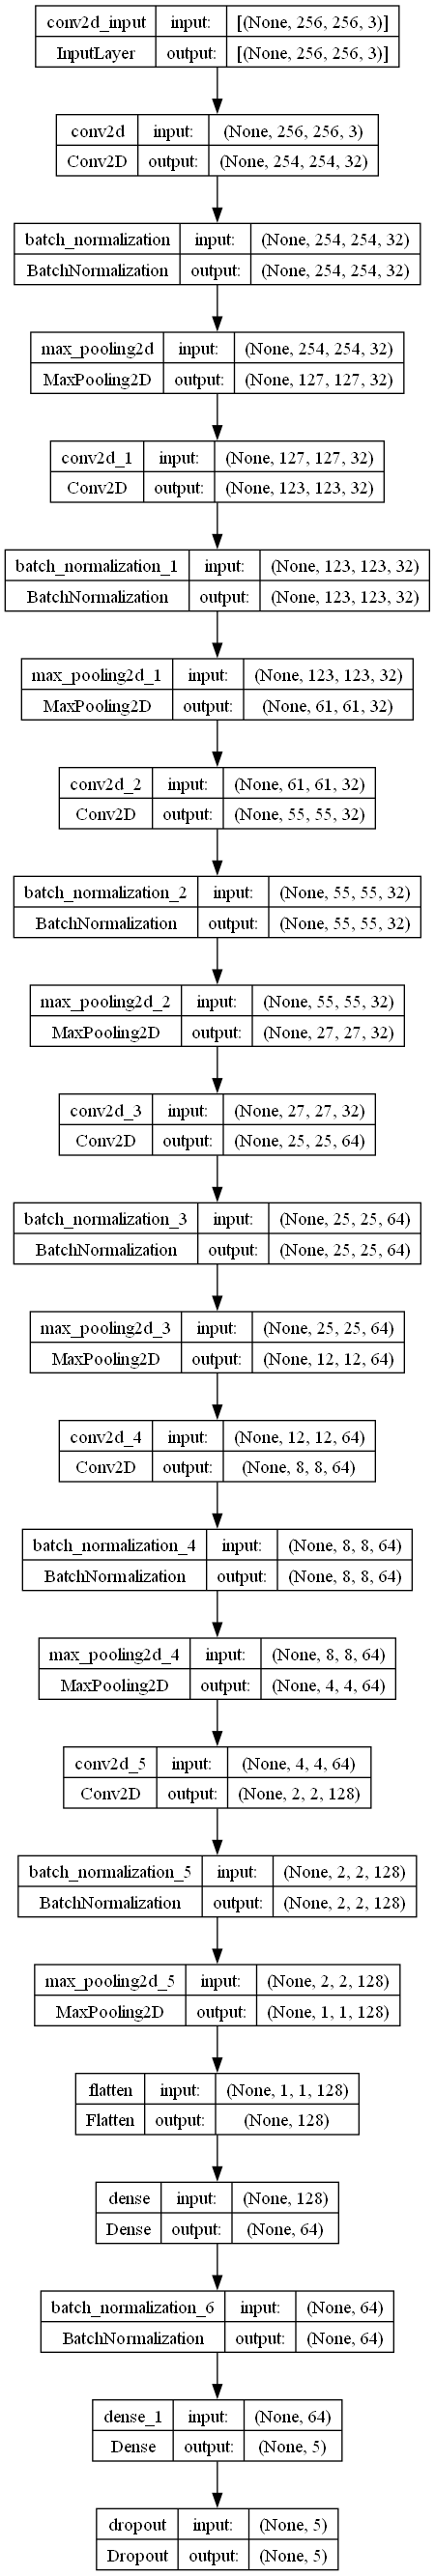

In [5]:
model = create_model(x_train[0].shape)
model.summary()

plot_model(model, to_file='models/models_summary_images/model_4_summary.png', show_shapes=True, show_layer_names=True)

In [6]:
batch_size = 32
epochs = 100

def lr_schedule(epoch):
        return initial_learning_rate * 0.9**epoch
lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(x_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(x_test, y_test), verbose=1, 
                    callbacks=[lr_scheduler, early_stopping])

model.save('models/trained_models/model_4.keras')

Epoch 1/100
85/85 [==============================] - 10s 77ms/step - loss: 4.3345 - accuracy: 0.3504 - val_loss: 1.8319 - val_accuracy: 0.2333 - lr: 0.0010
Epoch 2/100
85/85 [==============================] - 6s 71ms/step - loss: 3.9083 - accuracy: 0.4644 - val_loss: 5.5497 - val_accuracy: 0.1933 - lr: 9.0000e-04
Epoch 3/100
85/85 [==============================] - 6s 71ms/step - loss: 3.5560 - accuracy: 0.5274 - val_loss: 4.4169 - val_accuracy: 0.2333 - lr: 8.1000e-04
Epoch 4/100
85/85 [==============================] - 6s 70ms/step - loss: 3.4128 - accuracy: 0.5633 - val_loss: 9.9687 - val_accuracy: 0.1900 - lr: 7.2900e-04
Epoch 5/100
85/85 [==============================] - 6s 71ms/step - loss: 2.8531 - accuracy: 0.6356 - val_loss: 2.9819 - val_accuracy: 0.3833 - lr: 6.5610e-04
Epoch 6/100
85/85 [==============================] - 6s 72ms/step - loss: 2.5990 - accuracy: 0.6796 - val_loss: 2.1973 - val_accuracy: 0.5233 - lr: 5.9049e-04
Epoch 7/100
85/85 [==============================

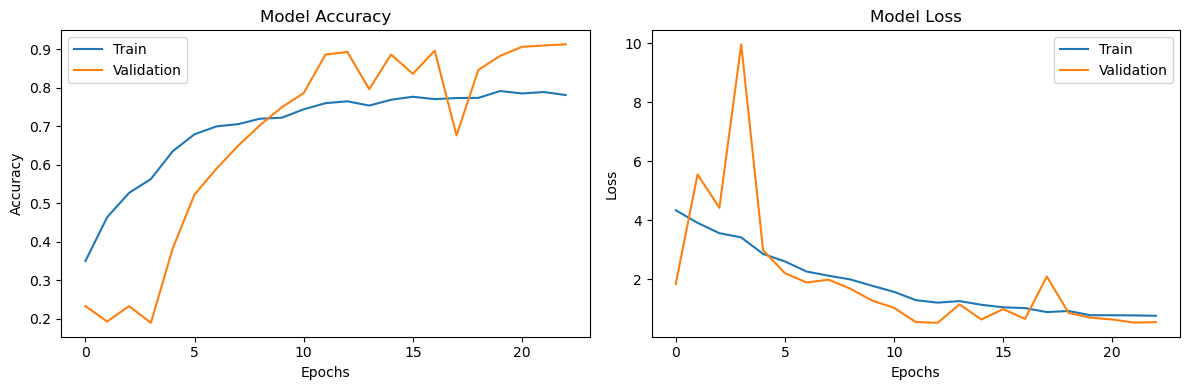

In [7]:
plot_model_history(history, "model_4_plot")

### Results - model 4
---
#### Train Accuracy
- slowly increases to ~78%, and plateu

#### Test Accuracy
- starts at ~18%, increases to ~91%, huge improvement

#### Train Loss
- decreases to ~75%

#### Test Loss
- decreases to ~53%

There is no gap between loss lines, but accuracy shows underfitting. Reduce regularization.

## Step 6 - Further improvements, tweaking
---
## 5. model
- changed two **ReLu** to **LeakyReLU** to mitigate the "dying ReLU" problem
- added **kernel initializers** to convolutional layers which determine how the initial weights of the layer are set

#### **23** layers:
- **6** **convolutional** layers:
 - convolutional layer with **32** filters of size **3x3**, using **ReLU** activation function and kernel initializer **He Normal**
 - convolutional layer with **32** filters of size **5x5**, using **ReLU** activation function and kernel initializer **He Normal**
 - convolutional layer with **32** filters of size **7x7**, using **LeakyReLU** activation function and kernel initializer **Lecun Normal**
 - convolutional layer with **64** filters of size **3x3**, using **ReLU** activation function
 - convolutional layer with **64** filters of size **5x5**, using **ReLU** activation function
 - convolutional layer with **128** filters of size **3x3**, using **LeakyReLU** activation function and kernel initializer **Lecun Normal**
- **7** **batch normalization** to stabilize and improve the training process by normalizing the inputs for each mini-batch
- **6** **max pooling** layers with a pool size of **2x2**, reducing the spatial dimensions
- **1** **flatten** layer
- **2** **dense** layers:
 - **densely connected** layer with **32** units, **ReLU** activation and **L2 regularization** with a regularization strength of **0.001** 
 - **output** layer, has as many units as there are categories with a **softmax** activation function
- **1** **dropout** layer with dropout rate of **0.075**

#### Compiling
- **Adam optimizer** with learning rate **0.0025** for adjusting the weights in the network to minimize the loss function
- **Sparse Categorical Crossentropy** loss function used for training the model, measures the error between the predicted and actual labels
- **Accuracy** metric, used during training for printing out accuracy

In [11]:
initial_learning_rate=0.0025

def create_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(32, (5, 5), activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(32, (7, 7), activation='LeakyReLU', kernel_initializer='lecun_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (5, 5), activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    # Layer 6 with ReLU activation
    model.add(Conv2D(128, (3, 3), activation='LeakyReLU', kernel_initializer='lecun_normal'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    
    # Dense Layer with ReLU activation and L2 regularization
    model.add(Dense(64, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    
    # Output Layer
    model.add(Dense(len(categories), activation='softmax'))
    model.add(Dropout(0.075))    

    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization_7 (Batc  (None, 254, 254, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 123, 123, 32)      25632     
                                                                 
 batch_normalization_8 (Batc  (None, 123, 123, 32)     128       
 hNormalization)                                                 
                                                      

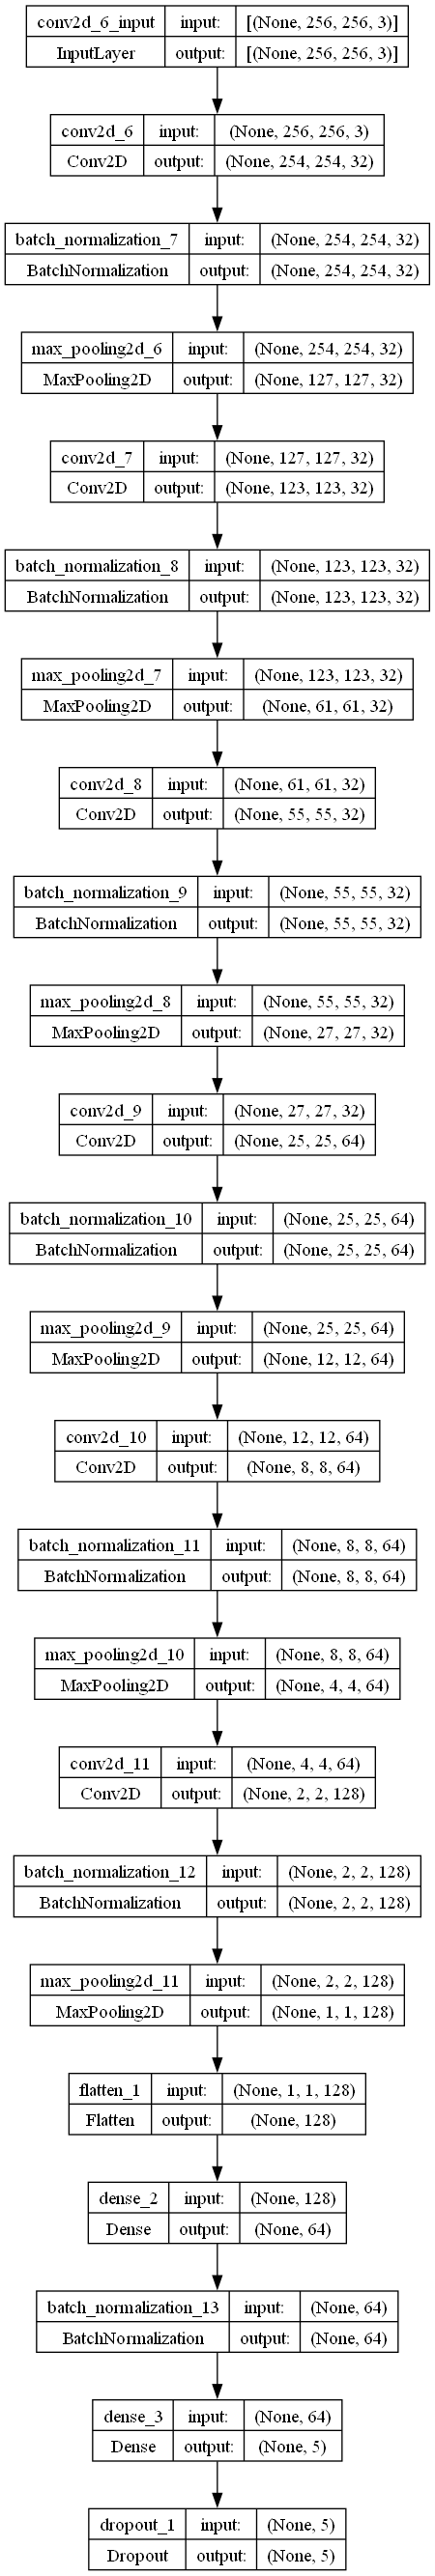

In [12]:
from tensorflow.keras.utils import plot_model
model = create_model(x_train[0].shape)
model.summary()

plot_model(model, to_file='models/models_summary_images/model_5_summary.png', show_shapes=True, show_layer_names=True)

In [16]:
batch_size = 32
epochs = 100
def lr_schedule(epoch):
        return initial_learning_rate * 0.9**epoch
lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history = model.fit(x_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=(x_test, y_test), verbose=1, 
                    callbacks=[lr_scheduler, early_stopping])

model.save('models/trained_models/model_5.keras')

Epoch 1/100
85/85 [==============================] - 6s 70ms/step - loss: 1.0687 - accuracy: 0.8215 - val_loss: 5.6016 - val_accuracy: 0.4300 - lr: 0.0025
Epoch 2/100
85/85 [==============================] - 6s 68ms/step - loss: 0.8715 - accuracy: 0.8481 - val_loss: 2.1639 - val_accuracy: 0.6533 - lr: 0.0022
Epoch 3/100
85/85 [==============================] - 6s 67ms/step - loss: 0.7728 - accuracy: 0.8619 - val_loss: 0.7490 - val_accuracy: 0.8567 - lr: 0.0020
Epoch 4/100
85/85 [==============================] - 6s 67ms/step - loss: 0.6321 - accuracy: 0.8774 - val_loss: 1.0407 - val_accuracy: 0.8300 - lr: 0.0018
Epoch 5/100
85/85 [==============================] - 6s 68ms/step - loss: 0.5803 - accuracy: 0.8889 - val_loss: 1.0845 - val_accuracy: 0.8133 - lr: 0.0016
Epoch 6/100
85/85 [==============================] - 6s 67ms/step - loss: 0.5849 - accuracy: 0.8856 - val_loss: 0.8331 - val_accuracy: 0.8833 - lr: 0.0015
Epoch 7/100
85/85 [==============================] - 6s 67ms/step - lo

85/85 [==============================] - 6s 67ms/step - loss: 0.1570 - accuracy: 0.9344 - val_loss: 0.4955 - val_accuracy: 0.9500 - lr: 1.1596e-05
Epoch 53/100
85/85 [==============================] - 6s 67ms/step - loss: 0.1902 - accuracy: 0.9204 - val_loss: 0.4928 - val_accuracy: 0.9533 - lr: 1.0436e-05
Epoch 54/100
85/85 [==============================] - 6s 67ms/step - loss: 0.1590 - accuracy: 0.9315 - val_loss: 0.4955 - val_accuracy: 0.9533 - lr: 9.3928e-06


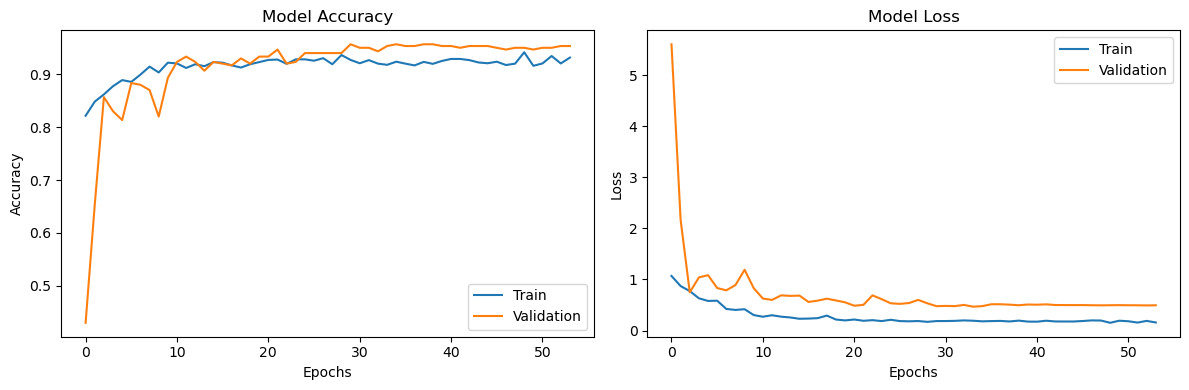

In [17]:
plot_model_history(history, "model_5_plot")

### Results - model 5
---
#### Train Accuracy
- increases to ~93%

#### Test Accuracy
- increases to ~95%

#### Train Loss
- decreases to ~15%

#### Test Loss
- decreases to ~49%

Lines in both graphs are very close indicating that the model is almost good.

Th-th-that's all, folks!